In [ ]:
from google.colab import files
uploaded = files.upload()


Saving fitness.db to fitness (1).db


In [ ]:
import sqlite3
import pandas as pd
import numpy as np

# Connect to the Fitness data set uploaded
conn = sqlite3.connect("fitness.db")

In [ ]:
df = pd.read_sql_query("""
SELECT w.*,
       u.gender,
       u.birthdate,
       u.signup_date,
       u.city
FROM workouts w
LEFT JOIN users u ON w.user_id = u.user_id
""", conn)


In [ ]:
# Sort by user and time to can compute lags
df["workout_datetime"] = pd.to_datetime(df["workout_datetime"])
df = df.sort_values(["user_id", "workout_datetime"])

# days_since_last: days between this workout and the previous one for that user
df["prev_workout_datetime"] = df.groupby("user_id")["workout_datetime"].shift(1)
df["days_since_last"] = (df["workout_datetime"] - df["prev_workout_datetime"]).dt.days
df["days_since_last"] = df["days_since_last"].fillna(0)   # first workout for each user

# workouts_next_7_days: how many workouts this user does in the NEXT 7 days
df["workouts_next_7_days"] = 0

for user in df["user_id"].unique():
    temp = df[df["user_id"] == user]
    times = temp["workout_datetime"].values

    counts = []
    for i in range(len(times)):
        start = times[i]
        end = start + np.timedelta64(7, "D")
        count = ((times > start) & (times <= end)).sum()
        counts.append(count)

    df.loc[temp.index, "workouts_next_7_days"] = counts


In [ ]:
# Datetime
df["workout_datetime"] = pd.to_datetime(df["workout_datetime"])
df["workout_hour"] = df["workout_datetime"].dt.hour
df["workout_dayofweek"] = df["workout_datetime"].dt.dayofweek

# Convert birthdate to age
df["birthdate"] = pd.to_datetime(df["birthdate"], errors="coerce")
df["age"] = (pd.Timestamp("today") - df["birthdate"]).dt.days / 365.25
df["age"] = df["age"].fillna(df["age"].median())

# Convert signup date to recency (days since signup)
df["signup_date"] = pd.to_datetime(df["signup_date"], errors="coerce")
df["days_since_signup"] = (df["workout_datetime"] - df["signup_date"]).dt.days
df["days_since_signup"] = df["days_since_signup"].fillna(df["days_since_signup"].median())

df = pd.get_dummies(df,
                    columns=["workout_type", "gender", "city"],
                    prefix=["type", "gender", "city"],
                    dummy_na=True)


In [ ]:
feature_cols = [
    "days_since_last",
    "duration_minutes",
    "calories_burned",
    "workout_hour",
    "workout_dayofweek",
    "age",
    "days_since_signup"
] + [c for c in df.columns if c.startswith("type_")] \
  + [c for c in df.columns if c.startswith("gender_")] \
  + [c for c in df.columns if c.startswith("city_")]


In [ ]:
model_df = df[feature_cols + ["workouts_next_7_days"]].dropna()
X = model_df[feature_cols]
y = model_df["workouts_next_7_days"]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression MSE:", mse_lr)
print("Linear Regression RMSE:", rmse_lr)
print("Linear Regression R²:", r2_lr)


Linear Regression MSE: 0.5763531272091336
Linear Regression RMSE: 0.7591792457708084
Linear Regression R²: -0.0023278321472326446


In [ ]:
coef_table = pd.DataFrame({
    "feature": X.columns,
    "coefficient": lr.coef_
}).sort_values(by="coefficient", key=np.abs, ascending=False)

coef_table.head(15)


,feature,coefficient
18,city_Boston,0.054272
19,city_Chicago,-0.050320
11,type_yoga,-0.043612
17,city_Austin,0.023471
7,type_bike,0.019976
8,type_class,0.013871
20,city_New York,-0.012830
22,city_Seattle,-0.012287
9,type_run,0.009173
4,workout_dayofweek,-0.008243


In [ ]:
# Random Forest Model

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest MSE:", mse_rf)
print("Random Forest RMSE:", rmse_rf)
print("Random Forest R²:", r2_rf)


Random Forest MSE: 0.5802486080089343
Random Forest RMSE: 0.7617405122539659
Random Forest R²: -0.009102409469545991


              feature  importance
6   days_since_signup    0.171864
2     calories_burned    0.165428
5                 age    0.132506
1    duration_minutes    0.117290
0     days_since_last    0.106953
3        workout_hour    0.077020
4   workout_dayofweek    0.061429
7           type_bike    0.015105
8          type_class    0.014643
10      type_strength    0.014341
15           gender_O    0.012548
18        city_Boston    0.012471
13           gender_F    0.012357
9            type_run    0.012133
14           gender_M    0.012055


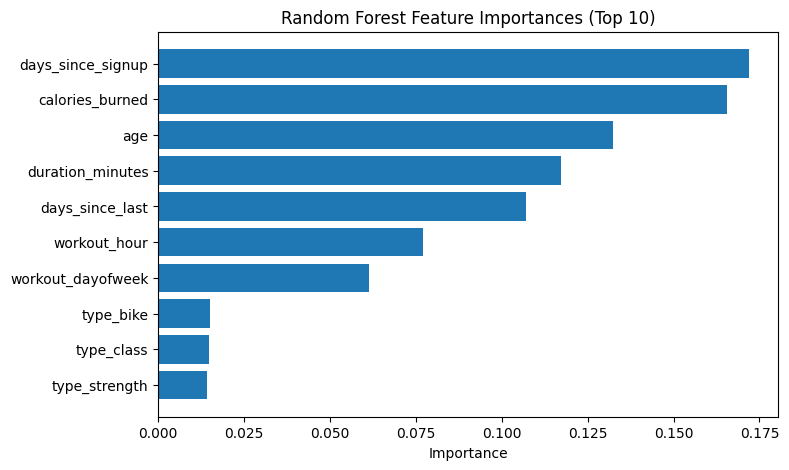

In [ ]:
import matplotlib.pyplot as plt

importances = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

print(importances.head(15))

plt.figure(figsize=(8,5))
plt.barh(importances["feature"].head(10), importances["importance"].head(10))
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importances (Top 10)")
plt.xlabel("Importance")
plt.show()


In [ ]:
########## Task 4 ###################

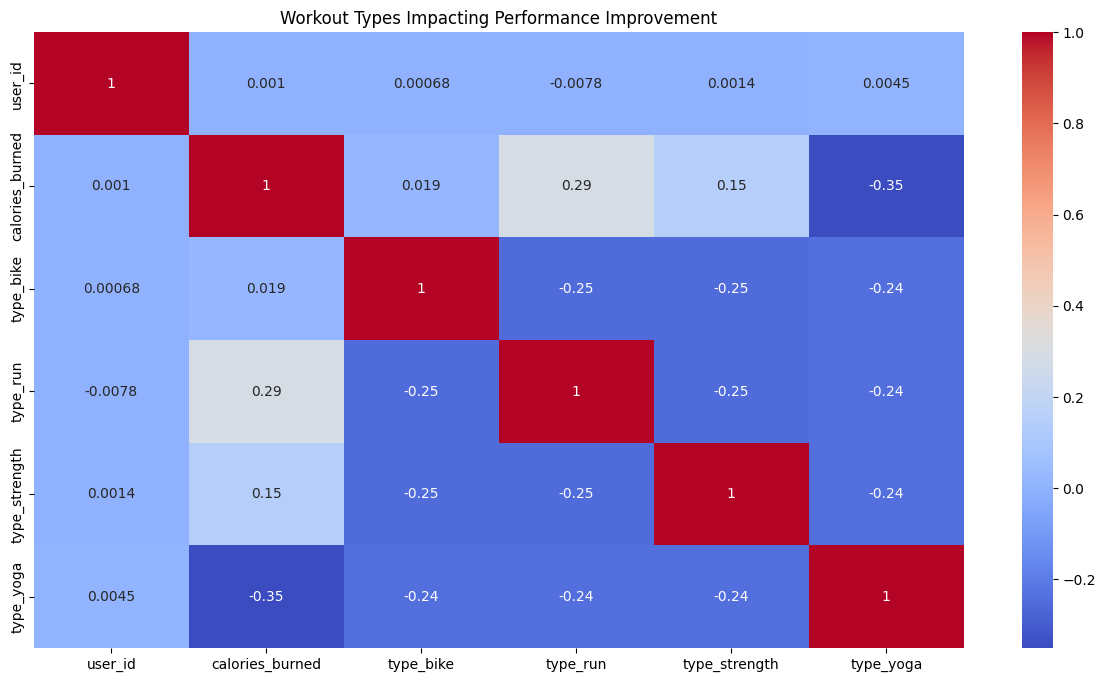

In [ ]:
#Correlation Matrix - Workout types Impacting Performance Improvement
import seaborn as sns

df_new = pd.read_sql_query("""
    SELECT w.user_id,
           w.calories_burned,
           w.workout_type
    FROM workouts w
    LEFT JOIN users u ON w.user_id = u.user_id
    GROUP BY w.user_id;
""", conn)

columns_selected_list = ['user_id', 'calories_burned','type_bike','type_run','type_strength', 'type_yoga']

df_new = df[columns_selected_list]

plt.figure(figsize=(15, 8))

sns.heatmap(df_new.corr(), annot=True, cmap='coolwarm')
plt.title('Workout Types Impacting Performance Improvement')
plt.show()

# Summary
# This correlation matrix is meant to analyze the workout types impacting performance improvement, utilizing ‘calories_burned’, ‘user_id’, and the workout types - 'type_bike', 'type_run', 'type_strength', and 'type_yoga'.
# The insights from this correlation matrix visualization is that running is the top workout type impacting performance improvement at 0.24. Strength workout type follows in second place with 0.15, biking as a workout type follows in third place with 0.019, and yoga falls in last place with -0.35.

